In [4]:
import numpy as np
import pickle
import cv2
from os import listdir
import tensorflow as tf
from keras import backend as K 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
import albumentations as A
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './Dataset'
width=256
height=256
depth=3

In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        print(f"[INFO] Processing {plant_folder} ...")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing PlantVillage ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___healthy ...
[INFO] Image loading completed


In [8]:
image_size = len(image_list)

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [9]:
print(label_binarizer.classes_)


['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [12]:
np_image_list = np.array(image_list) / 225.0

print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.3, random_state = 42) 

aug = A.Compose([
    A.Rotate(limit=25),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    # Add more augmentation techniques as needed
])

[INFO] Spliting data to train, test


In [13]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.training= False

/Users/shivam/Desktop/PracticeProject/Plant-Leaf-Disease-Detection/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 85, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 58,102,671 (221.64 MB)

 Trainable params: 58,099,791 (221.63 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=INIT_LR / EPOCHS,
    decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule)

In [16]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=INIT_LR / EPOCHS,
    decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule)

# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [17]:
# Apply augmentation to the training dataset after converting to float32
x_train_augmented = np.array([aug(image=image.astype(np.float32))['image'] for image in x_train])

In [18]:
history = model.fit(
    x_train_augmented, y_train,
    validation_data=(x_test, y_test),
    steps_per_epoch= len(x_train) // BS,
    epochs=10, verbose=1
    )

Epoch 1/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1259 - loss: 1.3582

2024-04-24 09:50:07.539383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


64/64 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.1259 - loss: 1.3586 - val_accuracy: 0.0564 - val_loss: 0.8575
Epoch 2/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.1369 - loss: 1.3783

2024-04-24 09:53:15.591848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.1368 - loss: 1.3784 - val_accuracy: 0.0564 - val_loss: 1.5146
Epoch 3/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1380 - loss: 1.3764

2024-04-24 09:56:41.856875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.1381 - loss: 1.3764 - val_accuracy: 0.0564 - val_loss: 2.1090
Epoch 4/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1325 - loss: 1.3789

2024-04-24 10:00:13.583157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.1326 - loss: 1.3789 - val_accuracy: 0.0564 - val_loss: 2.5843
Epoch 5/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1245 - loss: 1.3787

2024-04-24 10:03:58.910496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.1246 - loss: 1.3788 - val_accuracy: 0.0587 - val_loss: 2.9567
Epoch 6/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.1373 - loss: 1.3856

2024-04-24 10:08:03.253597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.1372 - loss: 1.3858 - val_accuracy: 0.0655 - val_loss: 2.9670
Epoch 7/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.1561 - loss: 1.3631

2024-04-24 10:11:15.688584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.1560 - loss: 1.3633 - val_accuracy: 0.0779 - val_loss: 2.7390
Epoch 8/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.1445 - loss: 1.3749

2024-04-24 10:14:28.596500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.1445 - loss: 1.3749 - val_accuracy: 0.0835 - val_loss: 2.4145
Epoch 9/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1228 - loss: 1.3868

2024-04-24 10:17:04.159457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.1230 - loss: 1.3867 - val_accuracy: 0.0858 - val_loss: 2.1528
Epoch 10/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.1424 - loss: 1.3825

2024-04-24 10:20:00.230674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.1423 - loss: 1.3825 - val_accuracy: 0.0914 - val_loss: 1.9573


In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

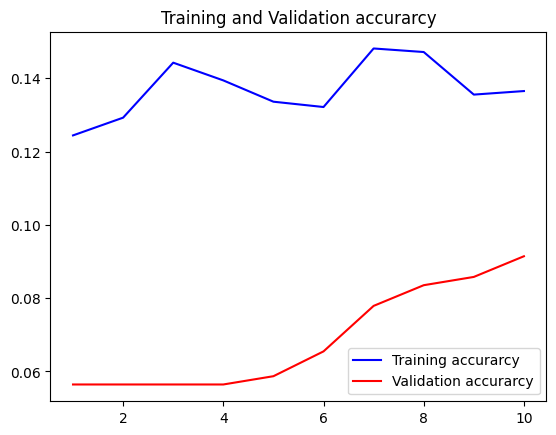

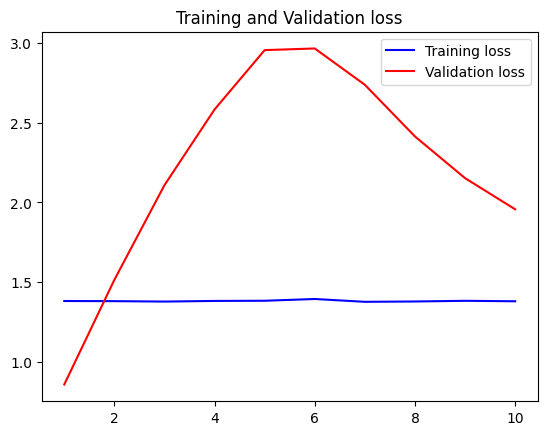

In [25]:
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [26]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.0916 - loss: 1.9105
Test Accuracy: 9.142211824655533


In [27]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
